In [1]:
import sys, os, re
sys.path.append(os.path.abspath('../'))

from glob import glob
from pathlib import Path

import cv2
import numpy as np
import tensorflow as tf
import seaborn as sns
sns.set_style('whitegrid')

from typing import List, Tuple

from tensorflow.python.keras.preprocessing.image_dataset import load_image
from tqdm import tqdm
import umap

from matplotlib import pyplot as plt
from IPython.display import display, HTML
from sklearn.cluster import KMeans, Birch
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import utils

In [2]:
def get_feature_extractor(model_path: str):
    weights = "imagenet" if model_path is None else None
    print(f"Using weights: {weights}")
    base_model = tf.keras.applications.ResNet50(
        input_shape=(32, 32, 3),
        include_top=False,
        weights=weights,
    )
    base_model = tf.keras.Model(
        base_model.inputs, outputs=[base_model.get_layer("conv2_block3_out").output]
    )

    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    model = tf.keras.Model(inputs, x)
    if model_path is not None:
        print(f"Loading weights: {model_path}")
        model.load_weights(model_path)
    return model

def get_feature_map(model: tf.keras.Model, data_dir: str) -> Tuple[List[Path], np.ndarray]:
    image_paths = list(sorted(Path(data_dir).glob("**/*.png")))
    n_samples = len(image_paths)
    feature_map = np.zeros((n_samples, 256))
    with tqdm(total=n_samples) as pbar:
        for i, image_path in enumerate(image_paths):
            img = load_image(str(image_path), image_size=(32,32), num_channels=3, interpolation="bilinear")
            img = tf.expand_dims(img, axis=0) # TensorShape: [1, 32, 32, 3]
            img_features = model(img) # TensorShape: [1, 256]
            img_features = img_features.numpy().squeeze() # Shape: (256,)
            feature_map[i, :] = img_features
            pbar.update(1)
    return image_paths, feature_map

In [3]:
experiment_dir = "../experiments/original"

In [4]:
model_path = os.path.join(experiment_dir, "checkpoints", "best_model")
# model_path = os.path.join(experiment_dir, "checkpoints", "imagenet-finetuned")
# model_path = None

In [5]:
model = get_feature_extractor(model_path)

Using weights: None
Loading weights: ../experiments/original/checkpoints/best_model


In [6]:
data_dir = os.path.join(experiment_dir, 'data', 'train', 'i')

In [7]:
image_paths, feature_map = get_feature_map(model, data_dir)

100%|██████████| 261/261 [00:13<00:00, 19.85it/s]


In [8]:
pca_transformer = PCA(n_components=0.9, svd_solver="full", whiten=True)

In [9]:
feature_map_pca = pca_transformer.fit_transform(feature_map)

In [10]:
feature_map_pca.shape

(261, 19)

In [11]:
outlier_detector = IsolationForest(n_estimators=1000)
if_labels = outlier_detector.fit_predict(feature_map_pca)
if_labels

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [12]:
np.where(if_labels == -1)

(array([ 54,  74,  77,  87,  89, 100, 123, 162, 165, 184, 244, 248]),)

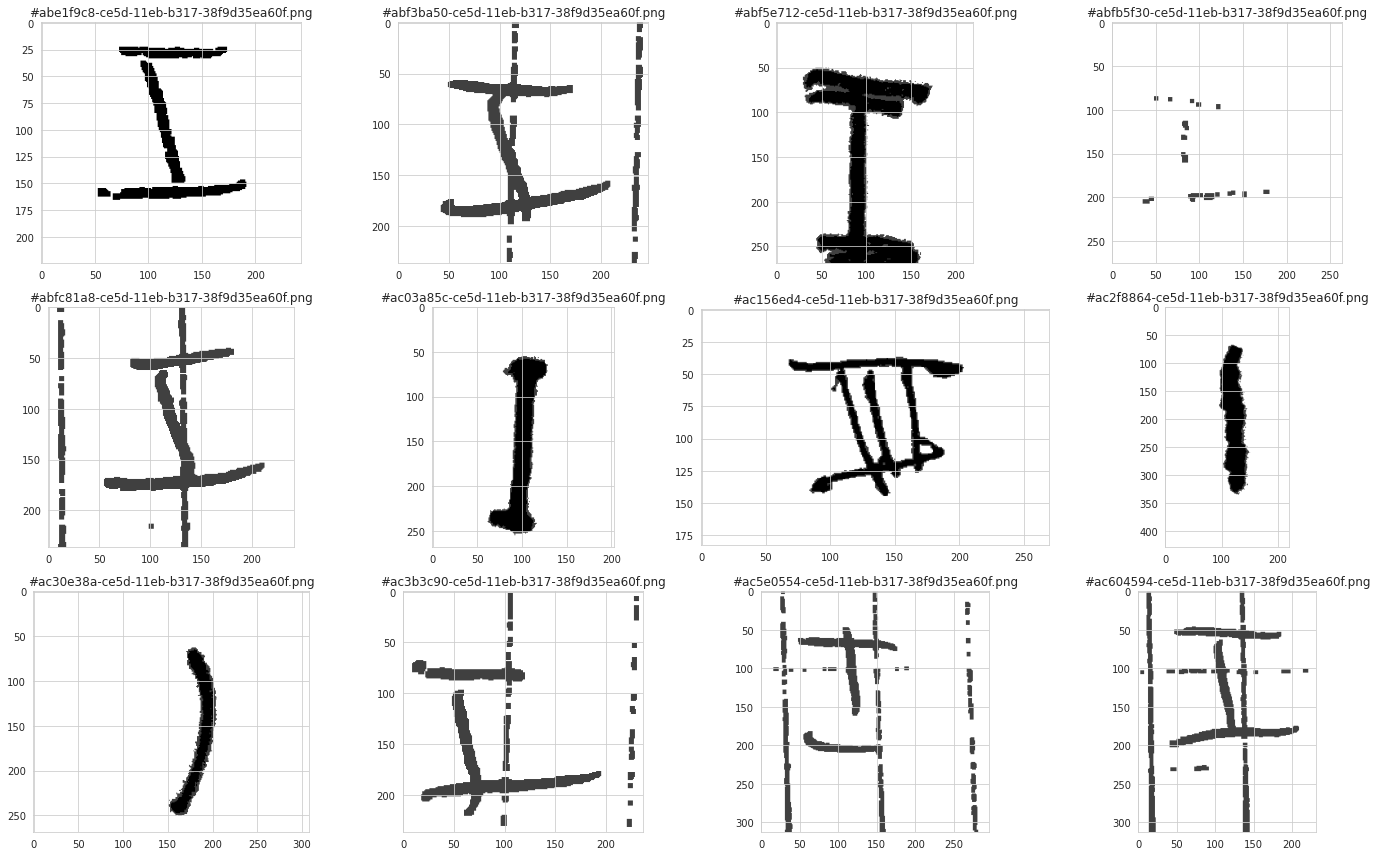

In [13]:
image_paths_in_cluster = np.array(image_paths)[(if_labels == -1)]

ncols = 4
nrows = int(np.ceil(len(image_paths_in_cluster) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
for ax, image_path in zip(axes.ravel(), image_paths_in_cluster):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    ax.set_title(f"#{image_path.name}")
    ax.imshow(img, cmap = "gray", vmin=0, vmax=255)
    #ax.axis('off')
fig.tight_layout()

In [14]:
svm = OneClassSVM()
outlier_svm_labels = svm.fit_predict(feature_map_pca)
outlier_svm_labels

array([-1, -1, -1, -1,  1,  1, -1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1,
        1,  1, -1,  1, -1,  1, -1, -1,  1,  1, -1,  1, -1, -1,  1,  1,  1,
       -1, -1, -1, -1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1, -1, -1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1,  1, -1,
        1, -1, -1,  1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1,  1,  1, -1,
       -1, -1, -1,  1, -1,  1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1,
        1,  1,  1, -1, -1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1,  1, -1,
        1, -1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1, -1,
        1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1,  1,  1,  1,
        1,  1, -1,  1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,  1,
       -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,
       -1,  1, -1, -1, -1, -1,  1, -1, -1,  1, -1,  1,  1,  1,  1, -1, -1,
        1, -1, -1,  1, -1, -1, -1, -1, -1,  1,  1, -1,  1, -1, -1,  1, -1,
        1,  1,  1,  1, -1

In [15]:
(outlier_svm_labels == -1).sum()

132

In [16]:
(outlier_svm_labels == -1).sum()

132

In [17]:
feature_map_pca.shape

(261, 19)

In [18]:
ee = EllipticEnvelope()
ee_labels = ee.fit_predict(feature_map_pca)
ee_labels

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1

In [19]:
(ee_labels == -1).sum()

26

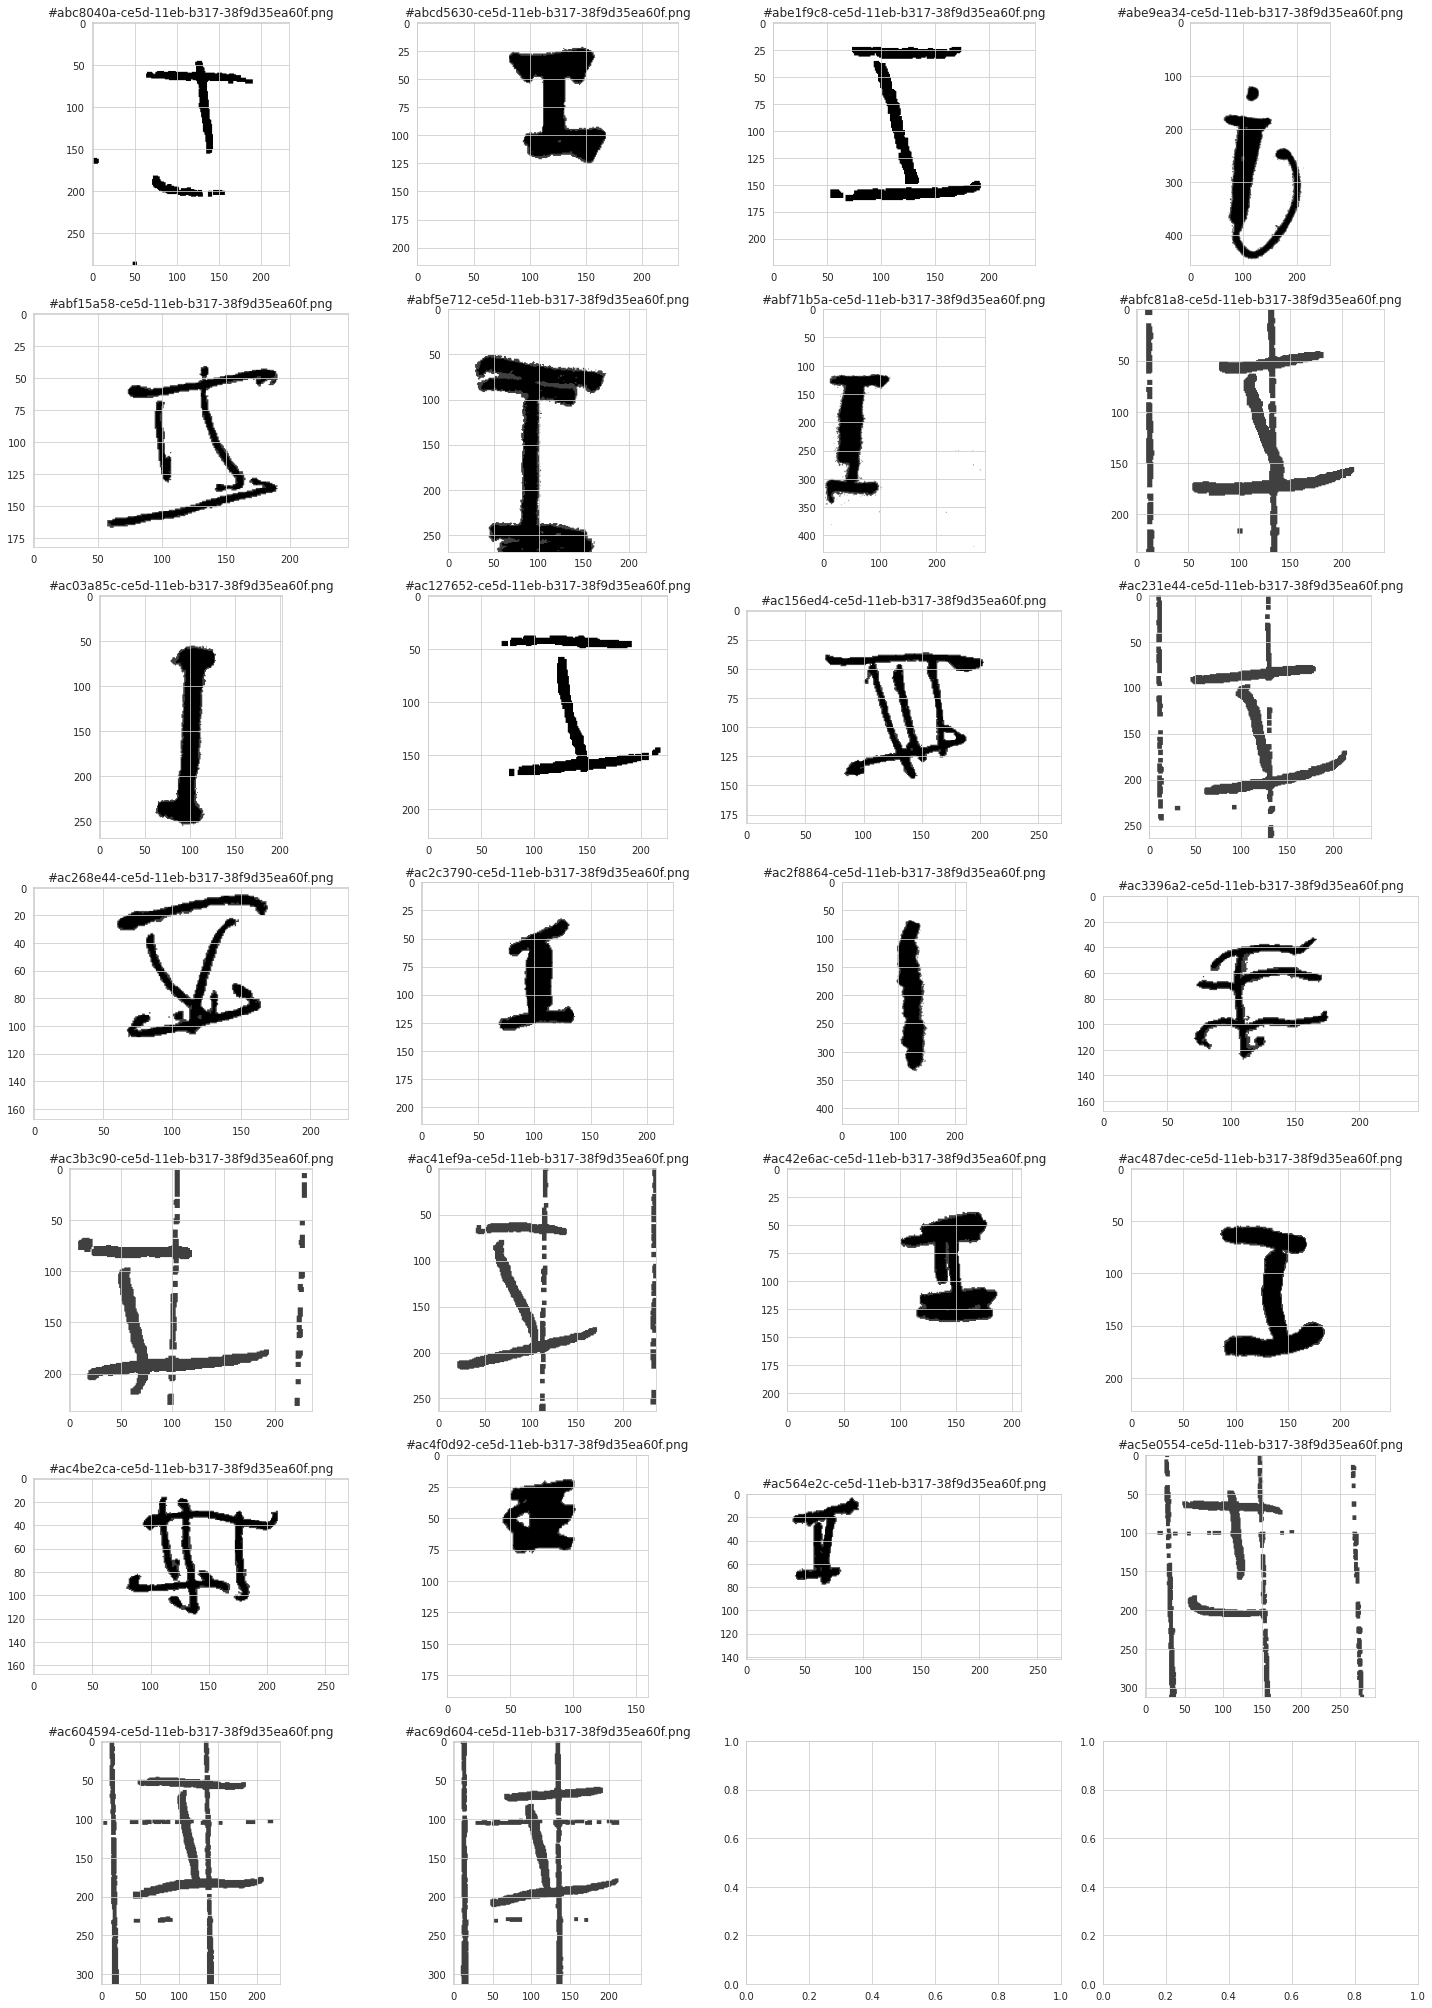

In [20]:
image_paths_in_cluster = np.array(image_paths)[(ee_labels == -1)]

ncols = 4
nrows = int(np.ceil(len(image_paths_in_cluster) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
for ax, image_path in zip(axes.ravel(), image_paths_in_cluster):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    ax.set_title(f"#{image_path.name}")
    ax.imshow(img, cmap = "gray", vmin=0, vmax=255)
    #ax.axis('off')
fig.tight_layout()